In [1]:
# from autoviz.AutoViz_Class import AutoViz_Class
# AV = AutoViz_Class()

import numpy as np
from tqdm import tqdm
import pandas as pd
from pathlib import Path

import matplotlib.pyplot as plt
import seaborn as sns

pd.options.display.max_columns = 100

targhe = [
"FY293YC", "FY295YC", "FY298YC", "FY294YC", "FY296YC", "FV903SK", "FV904SK", "FV906SK", "FV907SK", "FV908SK", "FZ330SC", "FV913SK", "FV914SK", "FY402YC", "FY403YC", "ZB477AN", "ZB473AN", "ZB474AN", "ZB476AN", "ZB475AN", "ZB478AN", "ZB137AR", "ZB139AR", "ZB150AR", "ZB127AR", "ZB132AR", "ZB128AR", "ZB131AR", "ZB130AR", "FY400YC", "ZB135AR", "ZB136AR", "ZB134AR", "ZB373AN", "FY401YC", "CW363HC", "CW367HC", "FP698BP", "FP699BP", "CW365HC", "CW368HC", "CN433CA", "FV989FV", "FV990FV", "FV991FV", "FV995FV", "FV996FV", "FV997FV", "FV992FV", "FV985FV", "FV987FV", "FV988FV", "FV993FV", "FV994FV", "EG181YE", "FV986FV", "EN971TN", "FY299YC", 
]
sns.set_style("whitegrid")

%matplotlib inline

In [2]:
veicoli = pd.read_excel("excels/SEA_Flotta_Elenco_Veicoli.xlsx", skiprows=lambda x: x > 341) # il file contiene altre cose dopo
veicoli = veicoli.drop(veicoli.columns[-5:-2], axis=1)[veicoli.TARGA.isin(targhe)]\
          .reset_index(drop=True).rename(columns=str.title).rename(columns=str.strip)
veicoli["plate"] = veicoli.Targa

veicoli["Sistema Gps Tracking"] = veicoli["Sistema Gps Tracking"].str.replace(' ', '').str.split('+')#.unique()
veicoli = veicoli.explode("Sistema Gps Tracking").groupby(['Targa', 'Sistema Gps Tracking']).first()

# Data cleaning - [VISIRUN](https://jupyter.polito.it/expert/hub/user-redirect/lab/tree/ai4Trucks/SEA%20Data%20Lake/VISIRUN)

In [3]:
!du -sh dataset/VISI*

309K	dataset/VISIONLINK_Location.csv
6.5K	dataset/VISIRUN_FleetOdometerOld.csv
846M	dataset/VISIRUN_RawTrackingData.csv
509M	dataset/VISIRUN_Route.csv


In [16]:
df_VIS_vehicles.shape

(545963, 12)

In [13]:
df_VIS_vehicles = pd.read_csv("dataset/VISIRUN_RawTrackingData.csv", index_col=0)
df_VIS_vehicles = df_VIS_vehicles[df_VIS_vehicles.vehiclePlate.isin(targhe)].drop_duplicates()
df_VIS_vehicles.datestamp = pd.to_datetime(df_VIS_vehicles.datestamp, format="%Y-%m-%dT%H:%M:%S")
df_VIS_vehicles.head()

,vehiclePlate,id,datestamp,gpsStatus,gsmStatus,latitude,longitude,altitude,speed,aux1,aux1Unit,aux2,aux2Unit,engine,digitalInput1,digitalInput2,digitalInput3,digitalInput4,gpsDistance,totalOdometer,canFuelLevelLitres,totalFuelConsumption,totalEngineHours,canRpmAvg,canIstantFuelEconomy,canServiceDistance,canPto,heading,externalPower,batteryLevel_mV,canSrvDistance,samplesWithSpeed_0,samplesWithSpeed_1_15,samplesWithSpeed_16_45,samplesWithSpeed_46_70,samplesWithSpeedOver_70,brakesNumber,samplesWithCruiseControl,samplesWithPto,samplesWithRpmBelow_800,samplesWithRpm_801_1100,samplesWithRpm_1101_1450,samplesWithRpm_1451_1700,samplesWithRpmOver_1700,istantFuelEconomy,samplesWithAcceleratorBelow_20,samplesWithAccelerator_20_39,samplesWithAccelerator_60_79,samplesWithAcceleratorOver_80,currentGear
0,ZB476AN,2847187045,2021-04-29 12:43:29,Fix GPS Complete (3D),Network Available,45.960194,8.420511,266,0.0,0.0,NaN,0.0,NaN,0,0,0,0,0,13,0,0.0,0,0.0,0,0.0,0,-1,NaN,0,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0,0,0,0,0
1,ZB476AN,2847187061,2021-04-29 12:43:53,Fix GPS Complete (3D),Network Available,45.960228,8.420530,267,0.0,0.0,NaN,0.0,NaN,0,0,0,0,0,10,0,0.0,0,0.0,0,0.0,0,-1,NaN,0,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0,0,0,0,0
2,ZB476AN,2847187091,2021-04-29 12:44:09,Fix GPS Complete (3D),Network Available,45.960230,8.420553,263,0.0,0.0,NaN,0.0,NaN,0,0,0,0,0,0,0,0.0,0,0.0,0,0.0,0,-1,NaN,0,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0,0,0,0,0
3,ZB476AN,2847187112,2021-04-29 12:45:05,Fix GPS Complete (3D),Network Available,45.960247,8.420566,241,0.0,0.0,NaN,0.0,NaN,0,0,0,0,0,27,0,0.0,0,0.0,0,0.0,0,-1,NaN,0,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0,0,0,0,0
4,ZB476AN,2847187137,2021-04-29 12:45:21,Fix GPS Complete (3D),Network Available,45.960266,8.420546,236,0.0,0.0,NaN,0.0,NaN,0,0,0,0,0,0,0,0.0,0,0.0,0,0.0,0,-1,NaN,0,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0,0,0,0,0


In [70]:
check = []
for pl, g in important[important.vehiclePlate.isin(anom_vehiclePlates)].groupby([""]):
    date_after = g[g.position_timestamp > anom_date[pl]].position_timestamp.min()
    check.append([
        pl,
        anom_date[pl],
        g[g.position_timestamp == anom_date[pl]].odometer.min(),
        date_after,
        g[g.position_timestamp == date_after].odometer.min()
    ])
    
Anomalies = pd.DataFrame(check, columns=["", "an_date", "km_an", "date_after", "km_after"])

In [14]:
useless_cols = [c for c in df_VIS_vehicles.columns if len(df_VIS_vehicles[c].unique()) == 1]
print(df_VIS_vehicles[useless_cols].iloc[0,:])

df_VIS_vehicles = df_VIS_vehicles.drop(useless_cols, axis=1)

gsmStatus                         Network Available
aux1                                            0.0
aux1Unit                                        NaN
aux2                                            0.0
aux2Unit                                        NaN
digitalInput3                                     0
digitalInput4                                     0
totalOdometer                                     0
canFuelLevelLitres                              0.0
totalFuelConsumption                              0
totalEngineHours                                0.0
canRpmAvg                                         0
canIstantFuelEconomy                            0.0
canServiceDistance                                0
canPto                                           -1
heading                                         NaN
externalPower                                     0
batteryLevel_mV                                 NaN
canSrvDistance                                    0
samplesWithS

In [19]:
df_VIS_vehicles.head()

,vehiclePlate,id,datestamp,gpsStatus,latitude,longitude,altitude,speed,engine,digitalInput1,digitalInput2,gpsDistance
0,ZB476AN,2847187045,2021-04-29 12:43:29,Fix GPS Complete (3D),45.960194,8.420511,266,0.0,0,0,0,13
1,ZB476AN,2847187061,2021-04-29 12:43:53,Fix GPS Complete (3D),45.960228,8.420530,267,0.0,0,0,0,10
2,ZB476AN,2847187091,2021-04-29 12:44:09,Fix GPS Complete (3D),45.960230,8.420553,263,0.0,0,0,0,0
3,ZB476AN,2847187112,2021-04-29 12:45:05,Fix GPS Complete (3D),45.960247,8.420566,241,0.0,0,0,0,27
4,ZB476AN,2847187137,2021-04-29 12:45:21,Fix GPS Complete (3D),45.960266,8.420546,236,0.0,0,0,0,0


---
## Elenco Targhe

In [22]:
fatture = pd.read_excel("excels/eventi_manutenzioni_esterne (da fatture).xlsx")

<AxesSubplot:title={'center':'Fatture per ogni targa'}, xlabel='Targa'>

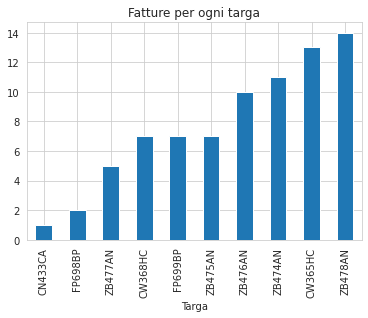

In [27]:
fatture[fatture.Targa.isin(df_VIS_vehicles.vehiclePlate.unique())].groupby("Targa").Telaio.count().sort_values().plot(kind="bar", title="Fatture per ogni targa")

---
## Monotonia

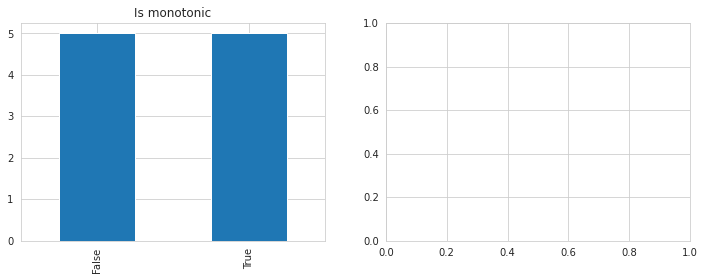

In [20]:
fig, ax = plt.subplots(1,2, figsize=(12,4))
df_VIS_vehicles.groupby('vehiclePlate').engine.apply(lambda x: x.is_monotonic_increasing).value_counts().sort_values(ascending=True).plot(kind="bar", title="Is monotonic", ax=ax[0])
# df_VIS_vehicles.groupby('vehiclePlate').odometer.apply(lambda x: x.is_monotonic_increasing).value_counts().plot(kind="bar", title="Is monotonic", ax=ax[1])
plt.show()

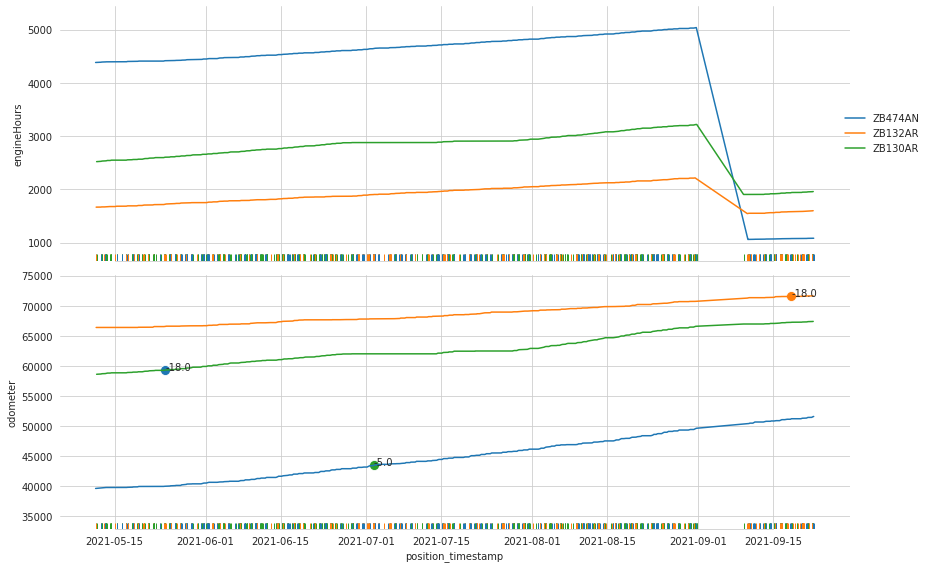

In [165]:
tmp = df_VIS_vehicles[df_VIS_vehicles.groupby('vehiclePlate').odometer.transform(lambda x: not x.is_monotonic_increasing)]
fig, ax = plt.subplots(2,1, figsize=(12,8), sharex=True)
sns.lineplot(data=tmp, x="position_timestamp", y="engineHours", hue="vehiclePlate", ax=ax[0])
sns.rugplot(data=tmp, x="position_timestamp", hue="vehiclePlate", ax=ax[0])

sns.lineplot(data=tmp, x="position_timestamp", y="odometer", hue="vehiclePlate", ax=ax[1])
sns.rugplot(data=tmp, x="position_timestamp", hue="vehiclePlate", ax=ax[1])

for i, (vehiclePlate, d) in enumerate(tmp.groupby('vehiclePlate')[["position_timestamp", "odometer"]]):
    d["df"] = d.odometer.diff().fillna(0)
    sns.scatterplot(data=d[d.df<0], x="position_timestamp", y="odometer", markers="*", s=100)
    plt.text(x=d[d.df<0].position_timestamp.values[0], y=d[d.df<0].odometer.values[0], s=str(d[d.df<0].df.values[0]))

fig.tight_layout()
ax[1].get_legend().remove()

sns.despine(trim=True, left=True)
ax[0].legend(frameon=False, loc="center right", bbox_to_anchor=(1.1,.5))
plt.show()

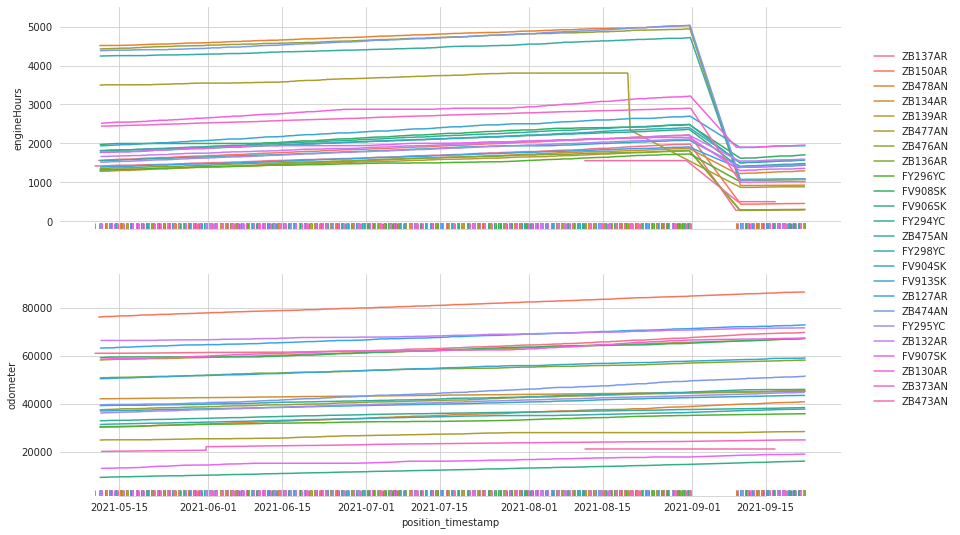

In [166]:
fig, ax = plt.subplots(2,1, figsize=(14,9), sharex=True)
tmp2 = df_VIS_vehicles[(df_VIS_vehicles.groupby('vehiclePlate').engineHours.transform(lambda x: not x.is_monotonic_increasing))&(df_VIS_vehicles.position_timestamp.dt.year == 2021)]
sns.lineplot(data=tmp2, x="position_timestamp", y="engineHours", hue="vehiclePlate", ax=ax[0])
sns.rugplot(data=tmp2, x="position_timestamp", hue="vehiclePlate", ax=ax[0])

ax[0].legend(frameon=False, loc="center right", bbox_to_anchor=(1.15,0))

sns.lineplot(data=tmp2, x="position_timestamp", y="odometer", hue="vehiclePlate", ax=ax[1])
sns.rugplot(data=tmp2, x="position_timestamp", hue="vehiclePlate", ax=ax[1])

sns.despine(trim=True, left=True)
ax[1].get_legend().remove()
plt.show()

In [167]:
df_VIS_vehicles[df_VIS_vehicles.position_timestamp.dt.date<pd.to_datetime("2021-09-01")].groupby('vehiclePlate').engineHours.apply(lambda x: x.is_monotonic_increasing).value_counts().sort_index(ascending=False)#.plot(kind="bar", title="Is monotonic (before 2021-09-01)")
# plt.show()

/home/students/s265780/.local/lib/python3.7/site-packages/pandas/core/ops/array_ops.py:73: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  result = libops.scalar_compare(x.ravel(), y, op)


True     33
False     2
Name: engineHours, dtype: int64

---
## Analisi Misurazioni giornaliere

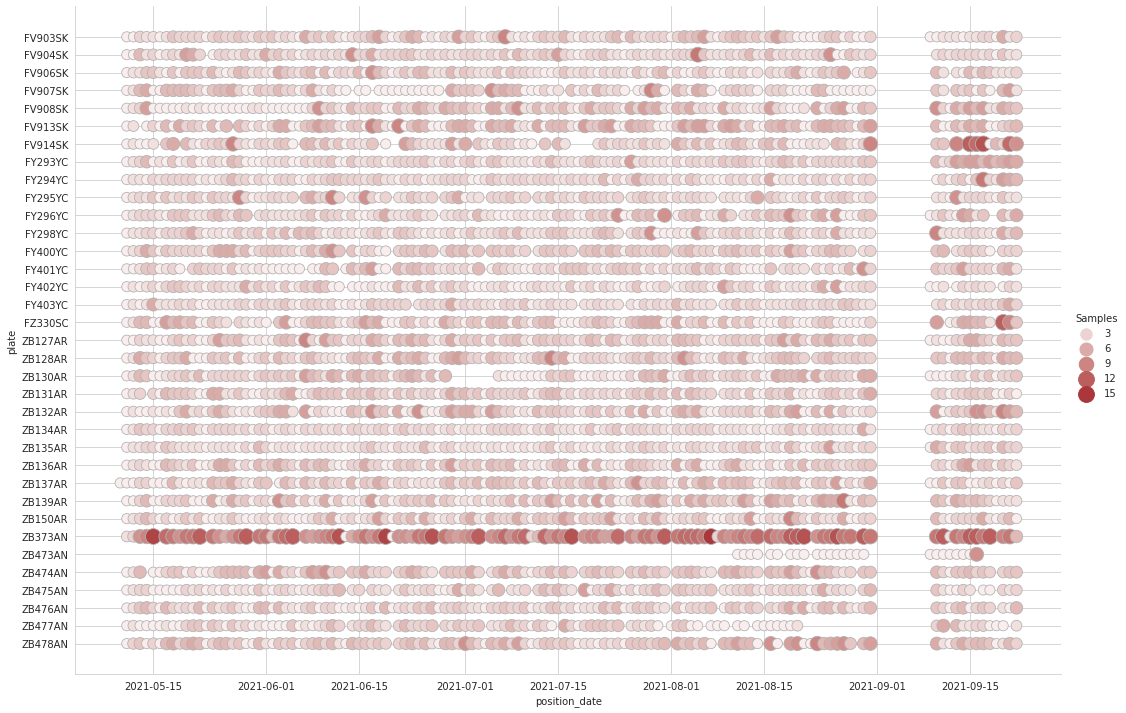

In [168]:
tmp = df_VIS_vehicles[df_VIS_vehicles.position_timestamp.dt.year == 2021].sort_values(by="position_date").groupby(["vehiclePlate", "position_date"], as_index=False).box.count()
tmp['c'] = tmp.box / tmp.box.max()
g = sns.relplot(
    data=tmp,
    x="position_date", y="vehiclePlate", hue="c", size="c",
    palette="vlag", hue_norm=(-1, 1), edgecolor=".7",
    height=10, sizes=(50, 250), size_norm=(-.2, .8), aspect=1.5
)

for t in g._legend.get_texts():
    t.set_text(int(float(t.get_text())*tmp.box.max()))
g._legend.set_title("Samples")

In [169]:
pd.read_json("SEA Data Lake/MOVIMATICA/vehicles/2021-08-03-06-vehicles.json")

,alarm_id,alarm_name,alarm_priority,alarm_tipology_id,alarm_tipology_label,box,brand,chassis,customId,engineHours,fleet_id,fleet_ilabel,hasTelemetry,id,lock_enabled,lock_locked,lock_status,model,name,odometer,plate,position_gps_lat,position_gps_lng,position_id,position_ignition,position_place_address,position_place_country_id,position_place_country_label,position_place_placeStr,position_place_state,position_place_zip,position_speed,position_timestamp,position_typology_id,position_typology_label,sav,typology_id,typology_label
0,0,,0,NONE,,D4257,Isuzu,TIS213369/18,,4894,0,,False,7425,True,False,disabled,M21,Isuzu M21,36656,ZB478AN,45.851800,8.563295,1185479184,False,Via Carcioni,IT,Italia,Belgirate,Piemonte,28832,16,2021-08-03T05:51:03+00:00,motion_stop,Fine movimento,TIS213369/18,COMPACTOR,Compattatore
1,0,,0,NONE,,D4324,Isuzu,TIS283444/18,,4821,0,,False,7428,True,False,disabled,M21,Isuzu M21,42872,ZB476AN,45.960064,8.420602,1184329595,False,Via Alfredo di Dio,IT,Italia,Ornavasso,Piemonte,28877,1,2021-08-02T10:15:09+00:00,digital_input_change,Cambio Digital IN,TIS283444/18,COMPACTOR,Compattatore
2,0,,0,NONE,,D4314,Isuzu,TIS213368/18,,3807,0,,False,7430,True,False,disabled,M21,Isuzu M21,28019,ZB477AN,41.685920,12.474256,1184728883,False,Via Guglielmo Marconi,IT,Italia,Pomezia,Lazio,71,0,2021-08-02T13:31:05+00:00,digital_input_change,Cambio Digital IN,TIS213368/18,COMPACTOR,Compattatore
3,0,,0,NONE,,D6190,Isuzu,TIS433613/18,,1781,0,,False,9606,True,False,disabled,P75,Isuzu P75,69114,ZB127AR,44.543140,7.830151,1185516798,False,Via Lequio Tanaro,IT,Italia,Bene Vagienna,Piemonte,12041,12,2021-08-03T06:08:09+00:00,motion_stop,Fine movimento,TIS433613/18,COMPACTOR,Compattatore
4,0,,0,NONE,,D7349,Isuzu,TIS114471/20,,24,0,,True,11531,True,False,disabled,L35,Isuzu L35,162,D7349,37.354850,13.623057,1185377058,False,Zona Industriale Agrigento,IT,Italia,Favara,Sicilia,92026,0,2021-08-03T04:45:27+00:00,low_power,Basso consumo,TIS114471/20,COMPACTOR,Compattatore
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56,0,,0,NONE,,D4345,Volvo,TIMP23759/20,,632,0,,False,9847,True,False,disabled,FL 280,Volvo FL 280,13708,EA203TN,43.829950,11.184629,1185452243,True,Via Pietro Nenni 8,IT,Italia,Sesto Fiorentino,Toscana,50019,0,2021-08-03T05:36:23+00:00,motion_stop,Fine movimento,TIMP23759/20,COMPACTOR,Compattatore
57,0,,0,NONE,,D6250,Isuzu,TIS433614/18,,1859,0,,False,9720,True,False,disabled,P75,Isuzu P75,63483,ZB131AR,44.650845,8.028098,1185515687,True,Via Marconi 5,IT,Italia,Diano d'Alba,Piemonte,12055,0,2021-08-03T06:07:42+00:00,digital_input_change,Cambio Digital IN,TIS433614/18,COMPACTOR,Compattatore
58,0,,0,NONE,,D4256,Isuzu,TIS283439/18,,1559,0,,False,7417,True,False,disabled,M21,Isuzu M21,21263,ZB473AN,41.958810,12.697287,799512776,False,Via dei Castagni,IT,Italia,Guidonia Montecelio,Lazio,12,0,2020-10-03T08:31:04+00:00,communication,Comunicazione,TIS283439/18,COMPACTOR,Compattatore
59,0,,0,NONE,,D6226,Scania,TIMP44644/18,,2361,0,,False,9465,True,False,disabled,P280,Scania P280,63761,FV908SK,43.790940,11.153494,1185522975,True,Via San Donnino 48,IT,Italia,Firenze,Toscana,50145,0,2021-08-03T06:10:53+00:00,digital_input_change,Cambio Digital IN,TIMP44644/18,COMPACTOR,Compattatore


Text(0, 0.5, 'count')

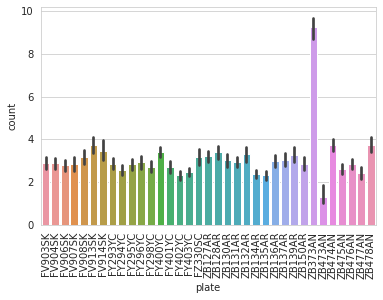

In [170]:
g = sns.barplot(data=tmp, x="vehiclePlate", y="box")
g.tick_params(axis='x', rotation=90)
g.set_ylabel("count")

In [171]:
df_VIS_vehicles[df_VIS_vehicles.vehiclePlate=="ZB373AN"].position_typology_id.value_counts().to_frame()

,position_typology_id
digital_input_change,847
motion_stop,193
position,3
external_power_on,1


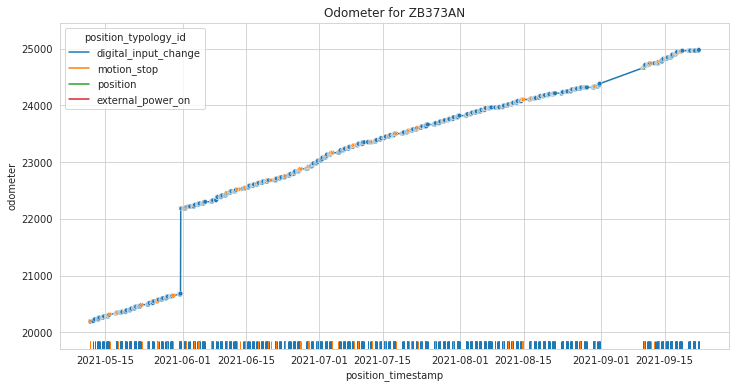

In [174]:
fig, ax = plt.subplots(figsize=(12, 6))
sns.lineplot(data=df_VIS_vehicles[df_VIS_vehicles.vehiclePlate=="ZB373AN"],
             x="position_timestamp",
             y="odometer",
             ax=ax
            )

sns.scatterplot(data=df_VIS_vehicles[df_VIS_vehicles.vehiclePlate=="ZB373AN"],
                x="position_timestamp",
                y="odometer",
                hue="position_typology_id",
                style="position_typology_id",
                ax=ax,
                zorder=4,
                s=20
               )
sns.rugplot(data=df_VIS_vehicles[df_VIS_vehicles.vehiclePlate=="ZB373AN"],
            x="position_timestamp",
            hue="position_typology_id"
           )
ax.set_title("Odometer for ZB373AN")
plt.show()

In [ ]:
# TO FIX!
tmp = df_VIS_vehicles.groupby(['vehiclePlate', "position_date"]).engineHours.count().reset_index()
g = sns.FacetGrid(tmp, row="vehiclePlate", aspect=2)
g.map(sns.barplot, "position_date", "engineHours")

---
## Correlation

In [176]:
df_VIS_vehicles.head()

,alarm_id,alarm_name,alarm_priority,alarm_tipology_id,box,brand,chassis,engineHours,id,model,name,odometer,plate,position_gps_lat,position_gps_lng,position_id,position_ignition,position_place_address,position_place_placeStr,position_place_state,position_place_zip,position_speed,position_timestamp,position_typology_id,position_typology_label,sav,position_date
119,0,NaN,0,NONE,D4256,Isuzu,TIS283439/18,1559,7417,M21,Isuzu M21,21263,ZB473AN,41.958810,12.697287,799512776,False,Via dei Castagni,Guidonia Montecelio,Lazio,12.0,0,2020-10-03 08:31:04+00:00,communication,Comunicazione,TIS283439/18,2020-10-03
35316,0,NaN,0,NONE,D4256,Isuzu,TIS283439/18,1559,7417,M21,Isuzu M21,21263,ZB473AN,41.958810,12.697287,799512776,False,Via dei Castagni,Guidonia Montecelio,Lazio,12.0,0,2020-10-03 08:31:04+00:00,communication,Comunicazione,TIS283439/18,2020-10-03
63045,0,NaN,0,NONE,D6258,Isuzu,TIS433608/18,1423,10297,M21,Isuzu M21,61051,ZB137AR,45.888203,8.525465,1060364362,False,Via Sempione Nord,Stresa,Piemonte,28838.0,0,2021-05-10 10:07:06+00:00,digital_input_change,Cambio Digital IN,TIS433608/18,2021-05-10
35269,0,NaN,0,NONE,D6181,Isuzu,TIS433605/18,1562,10267,M21,Isuzu M21,76114,ZB150AR,45.960815,8.420044,1060599894,True,Via Pra' del Fico 2,Ornavasso,Piemonte,28877.0,0,2021-05-11 03:12:11+00:00,digital_input_change,Cambio Digital IN,TIS433605/18,2021-05-11
35272,0,NaN,0,NONE,D4289,Isuzu,TIS083876/19,1465,9633,P75,Isuzu P75,27374,FY403YC,45.907375,10.840083,1060817768,False,Via Nuova 7,Riva del Garda,Trentino-Alto Adige,38066.0,1,2021-05-11 06:58:25+00:00,motion_stop,Fine movimento,TIS083876/19,2021-05-11


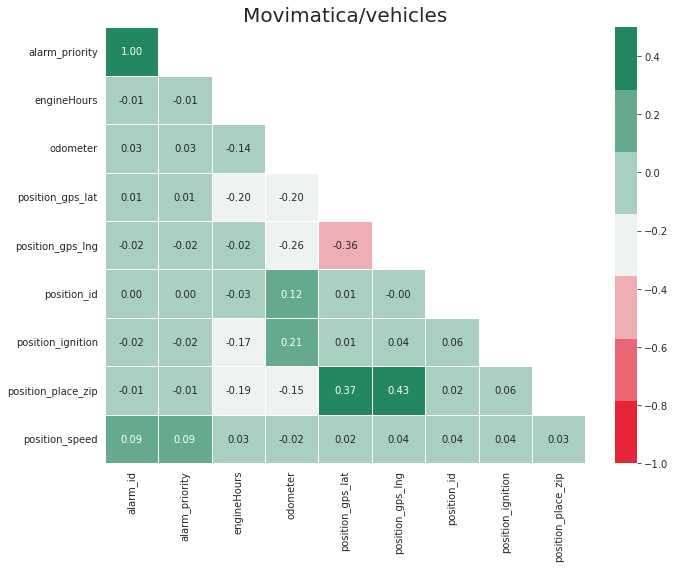

In [177]:
pseudo_plate = [c for c in df_VIS_vehicles.columns if len(df_VIS_vehicles[c].unique()) == 35]
correlations = df_VIS_vehicles.drop(pseudo_plate, axis=1).corr()

fig, ax = plt.subplots(figsize=(10,8))
mask = np.zeros_like(correlations)
mask[np.triu_indices_from(mask)] = True
heatmap = sns.heatmap(correlations.iloc[1:,:-1], annot=True, fmt='.2f', linewidths=0.5,
            mask=mask[1:,:-1], ax=ax, cmap=sns.diverging_palette(10, 150, s=90, n=7),
            robust=True, vmin=-1)#, annot_kws={"size": 10})
plt.title("Movimatica/vehicles", size=20)
plt.tight_layout()
# fig.savefig("corr.png")

In [178]:
df_VIS_vehicles[['alarm_id', 'alarm_priority', 'alarm_name', 'alarm_tipology_id']].drop_duplicates()

,alarm_id,alarm_priority,alarm_name,alarm_tipology_id
119,0,0,NaN,NONE
5502,1861321,4,Alert Alternatore,ANOMALY
96328,1825143,4,Alert Alternatore,ANOMALY
72828,1665634,4,Alert Alternatore,ANOMALY
4719,1830776,4,Alert Alternatore,ANOMALY
18332,1862428,4,Alert Alternatore,ANOMALY
75003,1790271,4,Alert Alternatore,ANOMALY
64314,1863512,4,Alert Alternatore,ANOMALY
36357,1665633,4,Alert Alternatore,ANOMALY


---
## PCA

In [179]:
data_std.dtypes.isin([np.dtype('int64'), np.dtype('float64'), np.dtype('bool')]).index

Index(['odometer', 'engineHours', 'position_speed', 'position_ignition'], dtype='object')

In [180]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# numerical_cols = df_VIS_vehicles.dtypes.isin([np.dtype('int64'), np.dtype('float64'), np.dtype('bool')])
# numerical_cols = df_VIS_vehicles.dtypes.isin([np.dtype('int64'), np.dtype('float64'), np.dtype('bool')])
# data_std = df_VIS_vehicles[numerical_cols[numerical_cols].index].drop(["id", "alarm_id"], axis=1)
data_std = df_VIS_vehicles[["odometer", "engineHours", "position_speed", "position_ignition"]].copy()

data_std[data_std.columns] = StandardScaler().fit_transform(data_std[data_std.columns])
data_std.head()

,odometer,engineHours,position_speed,position_ignition
119,-1.306122,-0.714378,-0.293483,-0.827088
35316,-1.306122,-0.714378,-0.293483,-0.827088
63045,0.927527,-0.852566,-0.293483,-0.827088
35269,1.773145,-0.711330,-0.293483,1.209062
35272,-0.963058,-0.809890,-0.151331,-0.827088


In [182]:
data_std = data_std.dropna()
pca = PCA(n_components=4)
pca.fit(data_std)
projection = pca.transform(data_std)

In [183]:
var_ratio = pca.explained_variance_ratio_
var_ratio

array([0.33576503, 0.25413525, 0.21557315, 0.19452656])

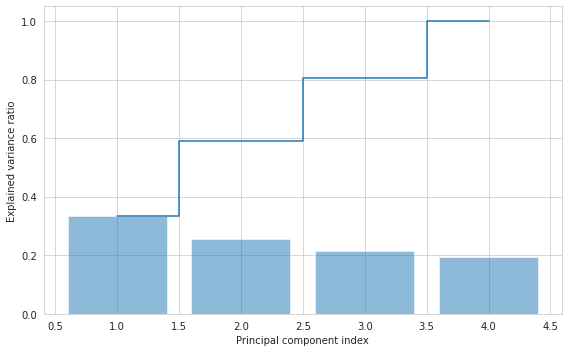

In [184]:
cum_sum_eigenvalues = np.cumsum(var_ratio)
plt.figure(figsize=(8, 5))
plt.bar(range(1, len(var_ratio) + 1), var_ratio, alpha=0.5, align='center', label='Individual explained variance')
plt.step(range(1, len(var_ratio) + 1), cum_sum_eigenvalues, where='mid',label='Cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
#plt.legend(loc='best')
plt.tight_layout()
# plt.savefig("PCA_6")
plt.show()

In [165]:
most_important = [np.argpartition(np.abs(pca.components_[i]), -3)[-3:] for i in range(len(var_ratio))]

In [167]:
initial_feature_names = data_std.columns
most_important_names = {i: initial_feature_names[most_important[i]].to_list() for i in range(len(var_ratio))}

In [168]:
most_important_names

{0: ['odometer', 'position_place_zip', 'position_gps_lng'],
 1: ['position_gps_lng', 'engineHours', 'position_gps_lat'],
 2: ['position_gps_lng', 'position_ignition', 'position_gps_lat'],
 3: ['position_id', 'alarm_priority', 'position_speed'],
 4: ['engineHours', 'alarm_priority', 'position_id'],
 5: ['position_ignition', 'alarm_priority', 'position_speed']}

**position_place_zip??**

In [134]:
pd.read_csv("dataset/VISIRUN_FleetOdometerOld.csv")

,Unnamed: 0,remoteUnitSerial,vehicleName,plate,odometer,engineOnTime
0,0,60039415,GC554HZ,GC554HZ,166899.1,18031:24
1,1,60039226,VISIRUN BOX 8,GDT00380,N.A.,N.A.
2,2,60013499,EV166DN,EV166DN,127606.42,15758:54
3,3,60013442,CW365HC,CW365HC,25376.17,3149:03
4,4,60013596,CX199WX,CX199WX,368722.54,2827:53
...,...,...,...,...,...,...
121,121,60013495,EV160DN,EV160DN,170225.6,16559:30
122,122,60002941,EV165DN EUROCARGO160,EV165DN,121596.24,18747:12
123,123,60025921,DR766RE VOLVO,DR766RE,543911.48,15946:36
124,124,60039249,ZB131AR,ZB131AR,55505.83,1891:52


In [196]:
df_dipendenti = pd.read_csv("dataset/DIPENDENTI_DipendentiList.csv", index_col=0).drop_duplicates()

In [215]:
df_dipendenti[['Nome', 'Cognome']].drop_duplicates()

,Nome,Cognome
0,CORNELIU,ADONICIOAE
1,PAVEL PETRONEL,ANDRISOAIA
2,SIMONA,AGNELLO
3,ROBERTO,AGOSTINI
4,ROBERTO,AGUELI
...,...,...
583,ALESSIO ANTONIO,PEZZOLATO
584,STEFANO,SGARAMELLA
585,DANIEL,PASQUARIELLO
586,NADIR,BOSSI


In [214]:
df_dipendenti.groupby([['Nome', 'Cognome']])#.idUtente#.transform('count')

ValueError: Grouper and axis must be same length

In [207]:
len(pd.read_csv("dataset/DIPENDENTI_DipendentiList.csv", index_col=0))/13

587.6153846153846